In [1]:
import numpy as np
import pandas as pd
from keras import models, layers

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
training_data_path = '../data/datasets/training_data_noisy_small_track_symetric_delayed_deviation.csv'
df = pd.read_csv(training_data_path)
print(f'{df.shape=}')
df.sample(5)

df.shape=(23760, 19)


,steering_angle,waypoint1_lat,waypoint1_lon,waypoint2_lat,waypoint2_lon,waypoint3_lat,waypoint3_lon,waypoint4_lat,waypoint4_lon,waypoint5_lat,waypoint5_lon,waypoint6_lat,waypoint6_lon,waypoint7_lat,waypoint7_lon,waypoint8_lat,waypoint8_lon,waypoint9_lat,waypoint9_lon
16939,0.300000,-2.518549,-3.550813,-5.955283,-4.893526,-10.114222,-5.621382,-13.502253,-7.081658,-16.187082,-6.038031,-19.763888,-6.499920,-21.896441,-5.354972,-23.539752,-1.155106,-24.295012,1.119039
910,-0.200000,-2.007206,0.328884,-5.373415,-0.087607,-8.522796,-1.319425,-10.994065,-3.637705,-12.975890,-6.397929,-14.892054,-9.205602,-16.489201,-12.206654,-18.088529,-15.206983,-19.687839,-18.207291
11604,0.241924,-2.947494,3.117956,-3.757017,5.417377,-3.502730,8.511429,-3.669755,12.210362,-4.356449,15.638086,-5.037376,18.969111,-5.718348,22.300238,-6.399290,25.631317,-6.886619,28.544798
22917,0.349688,-2.556417,1.482917,-5.573386,0.157436,-9.511897,-0.546037,-12.475560,-0.187641,-15.946558,-0.472200,-17.112348,1.026853,-17.970067,1.950061,-17.907580,6.259153,-18.467276,9.716528
21567,-0.311899,3.880483,-1.289537,3.607771,-5.642420,6.564915,-7.398529,6.706512,-12.662305,4.917301,-16.585660,0.647530,-18.633169,-2.445163,-20.296830,-5.799424,-20.720793,-9.448972,-20.393431


In [3]:
X = df.drop(columns=['steering_angle'])
y = df['steering_angle']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19008, 18), (4752, 18), (19008,), (4752,))

In [4]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [5]:
y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

metrics_df = pd.DataFrame({
    "Metric": ["Mean Squared Error (MSE)", "Mean Absolute Error (MAE)", "R-squared (R2)"],
    "Value": [mse, mae, r2]
})

metrics_df

,Metric,Value
0,Mean Squared Error (MSE),0.006488
1,Mean Absolute Error (MAE),0.058075
2,R-squared (R2),0.880090


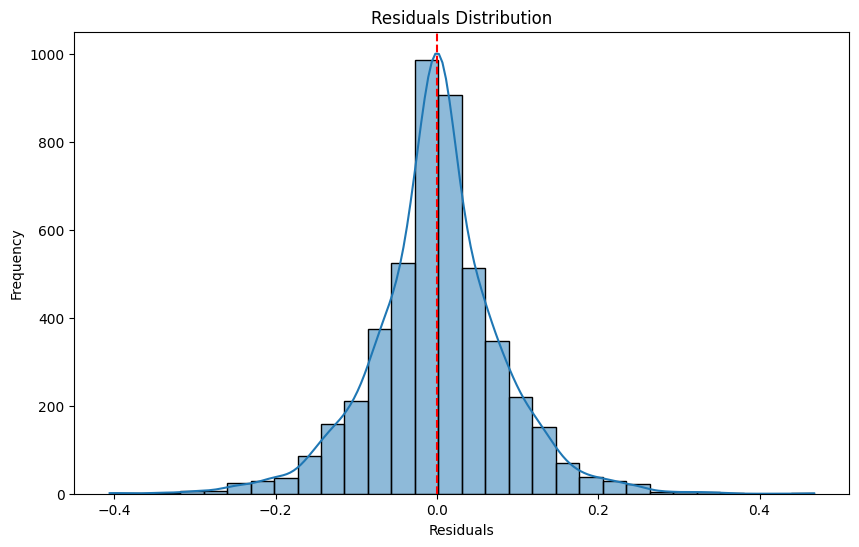

In [6]:
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

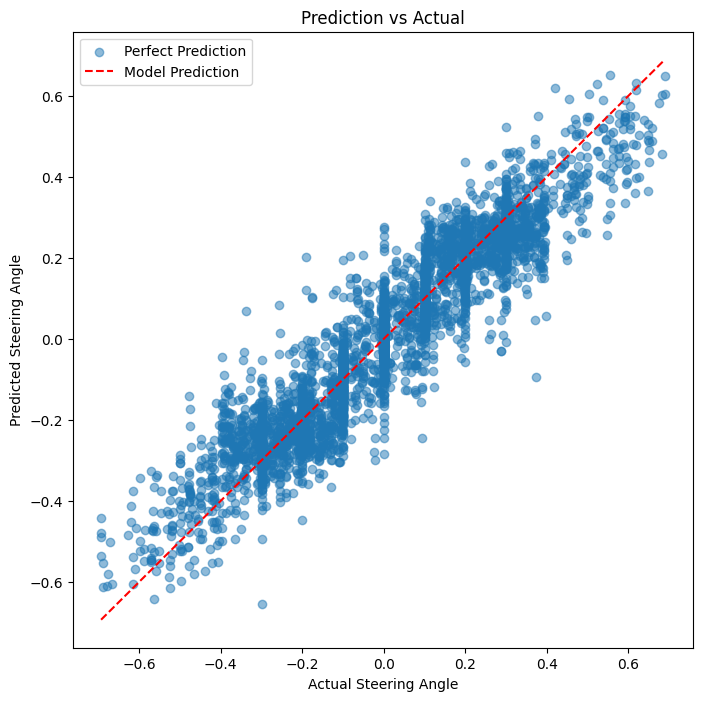

In [7]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Steering Angle')
plt.ylabel('Predicted Steering Angle')
plt.title('Prediction vs Actual')
plt.legend(['Perfect Prediction', 'Model Prediction'])
plt.show()

In [9]:
import joblib

name = 'xgboost'
model_path = f'../models/{name}.gz'

joblib.dump(xgb_model, model_path)

# Save the model parameters
model_params = {
    'n_estimators': xgb_model.get_params().get('n_estimators'),
    'max_depth': xgb_model.get_params().get('max_depth'),
    'learning_rate': xgb_model.get_params().get('learning_rate'),
    'subsample': xgb_model.get_params().get('subsample'),
    'colsample_bytree': xgb_model.get_params().get('colsample_bytree'),
    'random_state': xgb_model.get_params().get('random_state')
}

In [10]:
timestamp = pd.Timestamp.now().isoformat()
metadata = {
    "model_name": name,
    "model_path": f"../models/{name}.json",
    "training_data_path": training_data_path,
    "timestamp": timestamp,
    "input_shape": list(X_train.shape[1:]),
    "output_shape": [1],
    "optimizer": {
        "type": "Adam",
        "learning_rate": 0.001
    },
    "loss_function": "mse",
    "metrics": ["mae"],
    "training": model_params,
    "evaluation": {
        "mse": mse,
        "mae": mae,
        "r2": r2
    }
}

try:
    with open("metadata.jsonl", "r+") as f:
        lines = f.readlines()
        entry = json.dumps(metadata) + "\n"
        if entry not in lines:
            f.write(entry)
except FileNotFoundError:
    with open("metadata.jsonl", "w") as f:
        f.write(json.dumps(metadata) + "\n")

In [11]:
with open("metadata.jsonl", "r") as f:
    lines = f.readlines()

print(json.dumps(json.loads(lines[-1]), indent=4))

{
    "model_name": "xgboost",
    "model_path": "../models/xgboost.json",
    "training_data_path": "../data/datasets/training_data_noisy_small_track_symetric_delayed_deviation.csv",
    "timestamp": "2025-06-04T19:01:21.613362",
    "input_shape": [
        18
    ],
    "output_shape": [
        1
    ],
    "optimizer": {
        "type": "Adam",
        "learning_rate": 0.001
    },
    "loss_function": "mse",
    "metrics": [
        "mae"
    ],
    "training": {
        "n_estimators": 100,
        "max_depth": null,
        "learning_rate": null,
        "subsample": null,
        "colsample_bytree": null,
        "random_state": 42
    },
    "evaluation": {
        "mse": 0.006487671685179227,
        "mae": 0.05807496184693181,
        "r2": 0.8800904082099184
    }
}
